
Let's delve into the 'Insurance Claims' dataset, covering claims from 2021-2022, to pinpoint potential signs of fraud and aim for optimal accuracy in our fraud detection model.

**The dataset includes the following variables:**

* claim_number - Claim ID **(cannot be used in model)**
* age_of_driver - Age of driver
* gender - Gender of driver
* marital_status - Marital status of driver
* safty_rating - Safety rating index of driver
* annual_income - Annual income of driver
* high_education_ind - Driver’s high education index
* address_change_ind - Whether or not the driver changed living address in past 1 year
* living_status - Driver’s living status, own or rent
* zip_code - Driver’s living address zipcode
* claim_date - Date of first notice of claim
* claim_day_of_week - Day of week of first notice of claim
* accident_site - Accident location, highway, parking lot or local
* past_num_of_claims - Number of claims the driver reported in past 5 years
* witness_present_ind - Witness indicator of the claim
* liab_prct - Liability percentage of the claim
* channel - The channel of purchasing policy
* policy_report_filed_ind - Policy report filed indicator
* claim_est_payout - Estimated claim payout
* age_of_vehicle - Age of first party vehicle
* vehicle_category - Category of first party vehicle
* vehicle_price - Price of first party vehicle
* vehicle_color - Color of first party vehicle
* vehicle_weight - Weight of first party vehicle
* fraud - Fraud indicator (0=no, 1=yes). **This is the response variable.**

We will clean and prepare this data, perform feature engineering, and make it ready for analysis. In the final sections, we will discuss our model selection rationale and explore the main factors influencing fraud detection, concluding with insights on key fraud indicators.

In [ ]:
# this is to get rid of some annoying future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Import Libraries

Before data preprocessing, import all the required libraries and modules

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Oversampling
from imblearn.over_sampling import SMOTE

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


# classification spot check models!
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# more advanced ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

#Load and Analyze Dataset

In [ ]:
# Download the data using gdown
!gdown 1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq

Downloading...
From: https://drive.google.com/uc?id=1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq
To: /content/train_2023.csv
100% 2.62M/2.62M [00:00<00:00, 108MB/s]


In [ ]:
# Load the data
df = pd.read_csv('train_2023.csv')
df.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,0,50,F,1.0,66,39117,1,0,Own,50051,...,18,Broker,0,5464.903723,3.0,Large,16786.28845,blue,34183.436390,0
1,1,47,M,1.0,78,38498,1,0,Own,50012,...,81,Broker,0,5448.155974,4.0,Large,20793.29881,black,14528.379730,0
2,2,28,M,0.0,76,33343,0,1,Rent,20158,...,94,Broker,1,1858.971699,4.0,Compact,6729.47649,blue,7182.832636,0
3,3,36,M,1.0,56,35832,1,0,Own,50054,...,95,Phone,0,4040.932844,5.0,Compact,24914.26785,gray,47891.788790,0
4,4,60,F,1.0,79,40948,1,1,Rent,80010,...,53,Phone,1,4876.606138,6.0,Medium,17392.41997,black,7546.494014,0


In [ ]:
# hint: do you have imbalanced data?
df['fraud'].value_counts() # yes you do!

fraud
0    16062
1     2938
Name: count, dtype: int64

Our dataset shows an inbalance toward claims being classified as non-fraudlent (0).

We split the dataset.

First we create the X dataset by dropping claim_number (Identifier we dont want to impact the model) and the target variable fraud.

Next we create the Y dataset of just the target variable (fraud).

Then we can create our test/train datasets for X and Y using a 20% test partition.

In [ ]:
# split the data (don't change this!)

X = df.drop(['claim_number', 'fraud'],axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# check the shapes
print(df.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19000, 25)
(15200, 23) (15200,)
(3800, 23) (3800,)


The size of our test and train datasets aligns with our 20% test sample.

19,000 * 80% = 15,200

19,000 * 20% = 3,800


# 🔴 Data Cleaning

###  ◼ Train

In this section we want to understand our X_Train dataset, and update the indicies of the rows.

In [ ]:
# Indexes are shuffled, put them inplace
X_train.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
6787,46,F,1.0,50,38294,1,0,Rent,20116,6/6/2015,...,0.0,34,Broker,1,6420.369419,5.0,Large,12421.420480,gray,15723.35207
6097,35,M,1.0,77,35552,0,0,Own,50021,1/22/2016,...,0.0,32,Phone,1,3338.619246,1.0,Medium,22673.455310,red,15473.53232
11219,63,M,1.0,86,41432,0,1,Own,15003,2/2/2015,...,0.0,50,Phone,0,2784.762551,3.0,Compact,9208.723797,blue,25495.82584
2512,47,M,1.0,81,38502,1,0,Rent,15009,6/28/2015,...,1.0,50,Broker,0,4481.845804,4.0,Large,28051.151580,gray,35830.51049
4279,37,M,1.0,82,36102,0,0,Rent,20116,8/24/2016,...,1.0,76,Broker,1,4782.534213,8.0,Compact,38076.954140,white,41352.84911


In [ ]:
# Drop the existing indexes and create new ones
X_train.reset_index(drop=True,inplace=True)
X_train.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,46,F,1.0,50,38294,1,0,Rent,20116,6/6/2015,...,0.0,34,Broker,1,6420.369419,5.0,Large,12421.420480,gray,15723.35207
1,35,M,1.0,77,35552,0,0,Own,50021,1/22/2016,...,0.0,32,Phone,1,3338.619246,1.0,Medium,22673.455310,red,15473.53232
2,63,M,1.0,86,41432,0,1,Own,15003,2/2/2015,...,0.0,50,Phone,0,2784.762551,3.0,Compact,9208.723797,blue,25495.82584
3,47,M,1.0,81,38502,1,0,Rent,15009,6/28/2015,...,1.0,50,Broker,0,4481.845804,4.0,Large,28051.151580,gray,35830.51049
4,37,M,1.0,82,36102,0,0,Rent,20116,8/24/2016,...,1.0,76,Broker,1,4782.534213,8.0,Compact,38076.954140,white,41352.84911


In [ ]:
# Shape of X_train
X_train.shape

(15200, 23)

### ◼ Test

In this section we want to understand our X_Test dataset, and update the indicies of the rows.

In [ ]:
# Indexes are shuffled, put them inplace
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
7592,38,F,0.0,89,36375,1,0,Own,50036,10/29/2015,...,NaN,25,Phone,1,7680.245100,6.0,Medium,28774.345150,other,15850.26097
12051,53,F,1.0,75,39694,1,0,Own,85031,5/25/2016,...,0.0,95,Phone,1,2301.310573,2.0,Medium,7664.117156,other,16100.43385
17353,40,F,0.0,61,36881,0,1,Own,20142,8/13/2016,...,0.0,3,Phone,1,9937.850982,4.0,Medium,18207.880540,blue,54435.65309
17873,18,M,0.0,82,28910,1,1,Own,15021,11/17/2015,...,1.0,27,Broker,0,6168.819523,2.0,Compact,24368.446320,silver,25842.79507
18496,38,M,1.0,83,36370,1,0,Own,15042,9/10/2015,...,1.0,50,Phone,1,3452.248072,8.0,Large,29676.320760,blue,34512.56327


In [ ]:
# Drop the existing indexes and create new ones
X_test.reset_index(drop=True,inplace=True)
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,38,F,0.0,89,36375,1,0,Own,50036,10/29/2015,...,NaN,25,Phone,1,7680.245100,6.0,Medium,28774.345150,other,15850.26097
1,53,F,1.0,75,39694,1,0,Own,85031,5/25/2016,...,0.0,95,Phone,1,2301.310573,2.0,Medium,7664.117156,other,16100.43385
2,40,F,0.0,61,36881,0,1,Own,20142,8/13/2016,...,0.0,3,Phone,1,9937.850982,4.0,Medium,18207.880540,blue,54435.65309
3,18,M,0.0,82,28910,1,1,Own,15021,11/17/2015,...,1.0,27,Broker,0,6168.819523,2.0,Compact,24368.446320,silver,25842.79507
4,38,M,1.0,83,36370,1,0,Own,15042,9/10/2015,...,1.0,50,Phone,1,3452.248072,8.0,Large,29676.320760,blue,34512.56327


In [ ]:
# Check the shape
X_test.shape

(3800, 23)

### ✅ Missing Values and Data Type Conversion

In this section we want to identify and address data quality issues  and formatting in our X datasets.

### ◼ Train

In [ ]:
# Column info of X_train
X_train.info()

# Few columns have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15200 entries, 0 to 15199
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            15200 non-null  int64  
 1   gender                   15200 non-null  object 
 2   marital_status           15196 non-null  float64
 3   safty_rating             15200 non-null  int64  
 4   annual_income            15200 non-null  int64  
 5   high_education_ind       15200 non-null  int64  
 6   address_change_ind       15200 non-null  int64  
 7   living_status            15200 non-null  object 
 8   zip_code                 15200 non-null  int64  
 9   claim_date               15200 non-null  object 
 10  claim_day_of_week        15200 non-null  object 
 11  accident_site            15200 non-null  object 
 12  past_num_of_claims       15200 non-null  int64  
 13  witness_present_ind      15087 non-null  float64
 14  liab_prct             

In [ ]:
# Missing values per column
X_train.isna().sum()

age_of_driver                0
gender                       0
marital_status               4
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        113
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            18
age_of_vehicle               6
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
dtype: int64

The analysis of missing values for the train dataset shows we need to account for:

1) marital_status (4 rows)

2) witness_present_ind (113 rows)

3) claim_est_payout (18 rows)

4) age_of_vehicle (6 rows)

Lets look at our possible values for each field.

In [ ]:
print('Values for marital_status')
print(df['marital_status'].value_counts())
print('')

print('Values for witness_present_ind')
print(df['witness_present_ind'].value_counts())
print('')

print('Values for claim_est_payout')
print(df['claim_est_payout'].value_counts())
print('')

print('Values for age_of_vehicle')
print(df['age_of_vehicle'].value_counts())
print('')


Values for marital_status
marital_status
1.0    13613
0.0     5383
Name: count, dtype: int64

Values for witness_present_ind
witness_present_ind
0.0    14390
1.0     4467
Name: count, dtype: int64

Values for claim_est_payout
claim_est_payout
5464.903723    1
7343.208559    1
7525.174637    1
3336.787352    1
2418.921591    1
              ..
5643.564961    1
2278.732557    1
4395.965934    1
2466.592081    1
7337.796790    1
Name: count, Length: 18977, dtype: int64

Values for age_of_vehicle
age_of_vehicle
4.0     3293
5.0     3291
6.0     2762
3.0     2697
7.0     2001
2.0     1576
8.0     1261
1.0      688
9.0      687
10.0     345
11.0     156
0.0      134
12.0      65
13.0      23
14.0      12
16.0       1
15.0       1
Name: count, dtype: int64



Because Marital Status and witness present are categorical, we will impute their values based on the mode (most common value, 1 or 0).

Because claim_est_payout and age_of_vehicle are numeric values, we will use the median value to impute them.

In [ ]:
# Define a custom function to impute missing values in both train and test set
def impute_data(df):
    # Mode imputation for binary categorical data
    df['marital_status'].fillna(df['marital_status'].mode()[0], inplace=True)
    df['witness_present_ind'].fillna(df['witness_present_ind'].mode()[0], inplace=True)

    # Median imputation for numerical data
    df['claim_est_payout'].fillna(df['claim_est_payout'].median(), inplace=True)
    df['age_of_vehicle'].fillna(df['age_of_vehicle'].median(), inplace=True)
    return df

In [ ]:
# Apply custom function to impute train set
X_train = impute_data(X_train)

Now we can check to make sure we have accounted for all the missing values.

In [ ]:
# Check the missing values in train set to confirm imputation
X_train.isna().sum()

age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
dtype: int64

Now that we have no missing values in X_Train, lets make sure our datatypes align with what we want them to be.

In [ ]:
# look at the head
X_train.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,46,F,1.0,50,38294,1,0,Rent,20116,6/6/2015,...,0.0,34,Broker,1,6420.369419,5.0,Large,12421.420480,gray,15723.35207
1,35,M,1.0,77,35552,0,0,Own,50021,1/22/2016,...,0.0,32,Phone,1,3338.619246,1.0,Medium,22673.455310,red,15473.53232
2,63,M,1.0,86,41432,0,1,Own,15003,2/2/2015,...,0.0,50,Phone,0,2784.762551,3.0,Compact,9208.723797,blue,25495.82584
3,47,M,1.0,81,38502,1,0,Rent,15009,6/28/2015,...,1.0,50,Broker,0,4481.845804,4.0,Large,28051.151580,gray,35830.51049
4,37,M,1.0,82,36102,0,0,Rent,20116,8/24/2016,...,1.0,76,Broker,1,4782.534213,8.0,Compact,38076.954140,white,41352.84911


In [ ]:
# Unique values in each column to eye ball the data(unique categories and their count)
for col in X_train.columns:
  print('\n')
  print(X_train[col].value_counts())



age_of_driver
40     522
41     517
44     514
45     514
43     506
      ... 
90       1
100      1
229      1
95       1
96       1
Name: count, Length: 84, dtype: int64


gender
M    7953
F    7247
Name: count, dtype: int64


marital_status
1.0    10907
0.0     4293
Name: count, dtype: int64


safty_rating
81    473
84    464
83    463
86    451
87    450
     ... 
5       2
2       2
4       2
3       1
1       1
Name: count, Length: 99, dtype: int64


annual_income
37376    31
36636    29
37612    29
35834    29
37844    28
         ..
39096     1
29439     1
34684     1
35856     1
40453     1
Name: count, Length: 2584, dtype: int64


high_education_ind
1    10628
0     4572
Name: count, dtype: int64


address_change_ind
1    8688
0    6512
Name: count, dtype: int64


living_status
Own     8413
Rent    6787
Name: count, dtype: int64


zip_code
15012    258
15001    232
15025    191
80022    183
50047    177
        ... 
85039     26
80007     24
80110     22
20108     20
80036

In [ ]:
# Columns information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15200 entries, 0 to 15199
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            15200 non-null  int64  
 1   gender                   15200 non-null  object 
 2   marital_status           15200 non-null  float64
 3   safty_rating             15200 non-null  int64  
 4   annual_income            15200 non-null  int64  
 5   high_education_ind       15200 non-null  int64  
 6   address_change_ind       15200 non-null  int64  
 7   living_status            15200 non-null  object 
 8   zip_code                 15200 non-null  int64  
 9   claim_date               15200 non-null  object 
 10  claim_day_of_week        15200 non-null  object 
 11  accident_site            15200 non-null  object 
 12  past_num_of_claims       15200 non-null  int64  
 13  witness_present_ind      15200 non-null  float64
 14  liab_prct             

After reviewing the data types and unique values of each column, we've identified several adjustments that need to be made to ensure our data is properly formatted for analysis:

1) zip_code: needs conversion to object type (zip_codes do not possess any numeric properties and can not be used for any numerical analysis)

2) gender: needs label encoding and conversion to int type

3) living_status: needs label encoding and conversion to int type

4) claim_date: needs conversion to datetime type

5) claim_day_of_week: needs one hot encoding(it has 7 categories, we didn't opt for label encoding to prevent misleading ordinal relationship interpretation among the categories. In other words, we opted for dummies to maintain nominal nature of categories)

6) accident_site: needs label encoding and conversion to int type

7) channel: needs label encoding and conversion to int type

8) vehicle_category: needs label encoding and conversion to int type

9) vehicle_color: needs one hot encoding and conversion to int type(claim_day_of_week reasoning applies here as well)




In [ ]:
# Convert zipcode to object type
X_train['zip_code'] = X_train['zip_code'].astype(str)
print('Datatype of zipcode:',X_train.dtypes['zip_code'])

# Apply label encoding and convert few categorical columns to int type
X_train['gender'] = X_train['gender'].map({'M':0,'F':1}).astype(int)
print('Datatype of gender:',X_train.dtypes['gender'])
X_train['living_status'] = X_train['living_status'].map({'Rent':0,'Own':1}).astype(int)
print('Datatype of living_status:',X_train.dtypes['living_status'])
X_train['accident_site'] = X_train['accident_site'].map({'Local':1,'Parking Lot':2, 'Highway':3}).astype(int)
print('Datatype of accident_site:',X_train.dtypes['accident_site'])
X_train['channel'] = X_train['channel'].map({'Broker':1,'Phone':2, 'Online':3}).astype(int)
print('Datatype of channel:',X_train.dtypes['channel'])
X_train['vehicle_category'] = X_train['vehicle_category'].map({'Compact':1,'Large':2, 'Medium':3}).astype(int)
print('Datatype of vehicle_category:',X_train.dtypes['vehicle_category'])

# Create dummy variables for claim_day_of_week and vehicle_color columns
X_train = pd.concat([
    X_train.drop(['claim_day_of_week', 'vehicle_color'], axis=1),
    pd.get_dummies(X_train['claim_day_of_week'], prefix='claim_day',dtype=int),
    pd.get_dummies(X_train['vehicle_color'], prefix='vehicle_color',dtype=int)
], axis=1)

# Convert claim_date to datetime type
X_train['claim_date'] = pd.to_datetime(X_train['claim_date'])
print('Data type of claim_date:',X_train.dtypes['claim_date'])

Datatype of zipcode: object
Datatype of gender: int64
Datatype of living_status: int64
Datatype of accident_site: int64
Datatype of channel: int64
Datatype of vehicle_category: int64
Data type of claim_date: datetime64[ns]


In [ ]:
# Confirm the datatype conversion
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15200 entries, 0 to 15199
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   age_of_driver            15200 non-null  int64         
 1   gender                   15200 non-null  int64         
 2   marital_status           15200 non-null  float64       
 3   safty_rating             15200 non-null  int64         
 4   annual_income            15200 non-null  int64         
 5   high_education_ind       15200 non-null  int64         
 6   address_change_ind       15200 non-null  int64         
 7   living_status            15200 non-null  int64         
 8   zip_code                 15200 non-null  object        
 9   claim_date               15200 non-null  datetime64[ns]
 10  accident_site            15200 non-null  int64         
 11  past_num_of_claims       15200 non-null  int64         
 12  witness_present_ind      15200 n

* X_train has been cleaned through the imputation of missing values and conversion of column data types.

### ◼ Test

After cleaning the training data, we must apply the same transformations to the test data using our custom function to handle missing values.

In [ ]:
# Check the missing values per column
X_test.isna().sum()

age_of_driver               0
gender                      0
marital_status              0
safty_rating                0
annual_income               0
high_education_ind          0
address_change_ind          0
living_status               0
zip_code                    0
claim_date                  0
claim_day_of_week           0
accident_site               0
past_num_of_claims          0
witness_present_ind        30
liab_prct                   0
channel                     0
policy_report_filed_ind     0
claim_est_payout            5
age_of_vehicle              1
vehicle_category            0
vehicle_price               0
vehicle_color               0
vehicle_weight              0
dtype: int64

In [ ]:
# Apply custom function to impute test set
X_test = impute_data(X_test)

In [ ]:
# Confirm the imputation
X_test.isna().sum()

age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
dtype: int64

No Missing values in X_test. Now, Change the data types of few columns

In [ ]:
# Look at the head
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,38,F,0.0,89,36375,1,0,Own,50036,10/29/2015,...,0.0,25,Phone,1,7680.245100,6.0,Medium,28774.345150,other,15850.26097
1,53,F,1.0,75,39694,1,0,Own,85031,5/25/2016,...,0.0,95,Phone,1,2301.310573,2.0,Medium,7664.117156,other,16100.43385
2,40,F,0.0,61,36881,0,1,Own,20142,8/13/2016,...,0.0,3,Phone,1,9937.850982,4.0,Medium,18207.880540,blue,54435.65309
3,18,M,0.0,82,28910,1,1,Own,15021,11/17/2015,...,1.0,27,Broker,0,6168.819523,2.0,Compact,24368.446320,silver,25842.79507
4,38,M,1.0,83,36370,1,0,Own,15042,9/10/2015,...,1.0,50,Phone,1,3452.248072,8.0,Large,29676.320760,blue,34512.56327


In [ ]:
# Column Information
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            3800 non-null   int64  
 1   gender                   3800 non-null   object 
 2   marital_status           3800 non-null   float64
 3   safty_rating             3800 non-null   int64  
 4   annual_income            3800 non-null   int64  
 5   high_education_ind       3800 non-null   int64  
 6   address_change_ind       3800 non-null   int64  
 7   living_status            3800 non-null   object 
 8   zip_code                 3800 non-null   int64  
 9   claim_date               3800 non-null   object 
 10  claim_day_of_week        3800 non-null   object 
 11  accident_site            3800 non-null   object 
 12  past_num_of_claims       3800 non-null   int64  
 13  witness_present_ind      3800 non-null   float64
 14  liab_prct               

Verify the data type of each column against the data and the number of unique values in those columns. Although this step isn't necessary since we've already analyzed the train data and know the column data types, just double-checking!). Ensure the data types in the test dataset align with those and the logic used in the training dataset.

In [ ]:
# Convert zipcode to object type
X_test['zip_code'] = X_test['zip_code'].astype(str)
print('Datatype of zipcode:', X_test.dtypes['zip_code'])

# Convert some of the categorical columns to int type
X_test['gender'] = X_test['gender'].map({'M': 0, 'F': 1}).astype(int)
print('Datatype of gender:', X_test.dtypes['gender'])
X_test['living_status'] = X_test['living_status'].map({'Rent': 0, 'Own': 1}).astype(int)
print('Datatype of living_status:', X_test.dtypes['living_status'])
X_test['accident_site'] = X_test['accident_site'].map({'Local': 1, 'Parking Lot': 2, 'Highway': 3}).astype(int)
print('Datatype of accident_site:', X_test.dtypes['accident_site'])
X_test['channel'] = X_test['channel'].map({'Broker': 1, 'Phone': 2, 'Online': 3}).astype(int)
print('Datatype of channel:', X_test.dtypes['channel'])
X_test['vehicle_category'] = X_test['vehicle_category'].map({'Compact': 1, 'Large': 2, 'Medium': 3}).astype(int)
print('Datatype of vehicle_category:', X_test.dtypes['vehicle_category'])

# Create dummy variables for claim_day_of_week and vehicle_color columns
X_test = pd.concat([
    X_test.drop(['claim_day_of_week', 'vehicle_color'], axis=1),
    pd.get_dummies(X_test['claim_day_of_week'], prefix='claim_day', dtype=int),
    pd.get_dummies(X_test['vehicle_color'], prefix='vehicle_color', dtype=int)
], axis=1)

# Convert claim_date to datetime type
X_test['claim_date'] = pd.to_datetime(X_test['claim_date'])
print('Data type of claim_date:', X_test.dtypes['claim_date'])

Datatype of zipcode: object
Datatype of gender: int64
Datatype of living_status: int64
Datatype of accident_site: int64
Datatype of channel: int64
Datatype of vehicle_category: int64
Data type of claim_date: datetime64[ns]


In [ ]:
# Confirm the datatype conversion of columns
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   age_of_driver            3800 non-null   int64         
 1   gender                   3800 non-null   int64         
 2   marital_status           3800 non-null   float64       
 3   safty_rating             3800 non-null   int64         
 4   annual_income            3800 non-null   int64         
 5   high_education_ind       3800 non-null   int64         
 6   address_change_ind       3800 non-null   int64         
 7   living_status            3800 non-null   int64         
 8   zip_code                 3800 non-null   object        
 9   claim_date               3800 non-null   datetime64[ns]
 10  accident_site            3800 non-null   int64         
 11  past_num_of_claims       3800 non-null   int64         
 12  witness_present_ind      3800 non-

* X_test has been cleaned by filling in missing values and converting column data types, replicating the transformations applied to X_train.

# 🔴EDA

We conducted Exploratory Data Analysis (EDA) to explore the relationships between variables and pinpoint any potential drivers of fraud.

### ◼ Plot-1 and table-1


What is the relationship between annual income and fraud?

<Figure size 800x600 with 0 Axes>

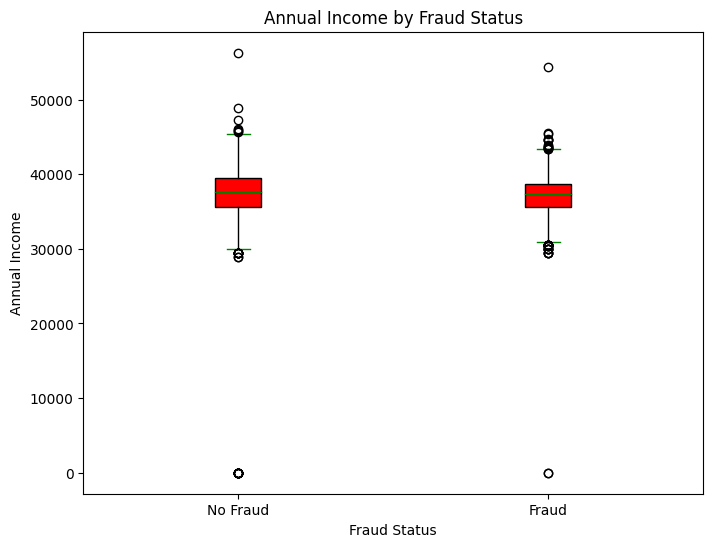

In [ ]:
# Creating a boxplot
plt.figure(figsize=(8, 6))
# Creating a boxplot
plt.figure(figsize=(8, 6))
box = plt.boxplot([df.loc[df['fraud'] == 0, 'annual_income'], df.loc[df['fraud'] == 1, 'annual_income']],
                  labels=['No Fraud', 'Fraud'],
                  patch_artist=True,  # Necessary for filling with color
                  boxprops=dict(facecolor='red'),  # Box color
                  whiskerprops=dict(color='black'),  # Whisker color
                  capprops=dict(color='green'),  # Caps color
                  medianprops=dict(color='green'))  # Median line color

plt.xlabel('Fraud Status')
plt.ylabel('Annual Income')
plt.title('Annual Income by Fraud Status')
plt.show()

* Annual incomes of the fraudulent claims and non-fraudulent claims are in the same range and even the mean income is the same.

In [ ]:
# Recode the annual income column with 1 and 0
df['median_annual_income'] = np.where(df['annual_income'] > np.median(df['annual_income']), 1, 0)

# Create a table to get the count of fraud and non-fraud claims grouping on annual income
tmp1 = df.groupby(['median_annual_income','fraud'])['claim_number'].agg(Count='count')
tmp1['Percentage'] = tmp1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values

# Display the table with counts and percentages
tmp1


Count  Percentage
median_annual_income fraud                   
0                    0       7887   82.794457
                     1       1639   17.205543
1                    0       8175   86.288790
                     1       1299   13.711210

* There isn't much difference in the count of fradulent and non-fradulent claims for annual income greater and less than the median. However, the fradulent claims are higher(17.2%) where annual income is lower than it's median, indicating lower incomes might influence the motivation to commit fraud.

### ◼ Plot-2 and table-2


What is the relationship between vehicle price and fraud?

<Figure size 800x600 with 0 Axes>

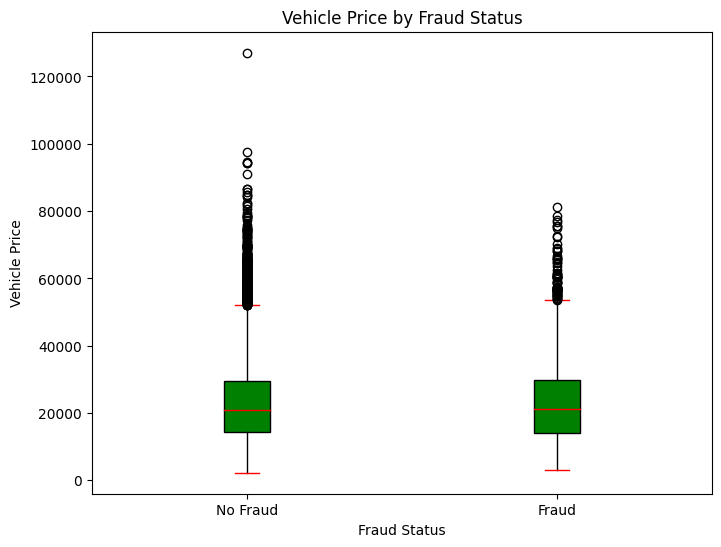

In [ ]:
# Creating a boxplot
plt.figure(figsize=(8, 6))
# Creating a boxplot
plt.figure(figsize=(8, 6))
box = plt.boxplot([df.loc[df['fraud'] == 0, 'vehicle_price'], df.loc[df['fraud'] == 1, 'vehicle_price']],
                  labels=['No Fraud', 'Fraud'],
                  patch_artist=True,  # Necessary for filling with color
                  boxprops=dict(facecolor='green'),  # Box color
                  whiskerprops=dict(color='black'),  # Whisker color
                  capprops=dict(color='red'),  # Caps color
                  medianprops=dict(color='red'))  # Median line color

plt.xlabel('Fraud Status')
plt.ylabel('Vehicle Price')
plt.title('Vehicle Price by Fraud Status')
plt.show()


* Vehicle price of the fraudulent claims and non-fraudulent claims are in the same range and even the mean vehilce price is the same.

In [ ]:
# Recode the vehicle price column with 1 and 0
df['median_vehicle_price'] = np.where(df['vehicle_price'] > np.median(df['vehicle_price']), 1, 0)

# Create a table to get the count of fraud and non-fraud claims grouping on annual income
tmp2 = df.groupby(['median_vehicle_price','fraud'])['claim_number'].agg(Count='count')
tmp2['Percentage'] = tmp2.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values

# Display the table with counts and percentages
tmp2

Count  Percentage
median_vehicle_price fraud                   
0                    0       8050   84.736842
                     1       1450   15.263158
1                    0       8012   84.336842
                     1       1488   15.663158

* The distribution of fraudulent claims for vehicles priced both below and above the median is nearly identical, with 15.2% for vehicles below the median price and 15.7% for those above it. This similarity suggests that vehicle price may not be a reliable indicator of fraud.

### ◼ Plot-3 and table-3

Estimated Claim Payout by Channel, and Fraudulent vs. Non-Fraudulent Claims

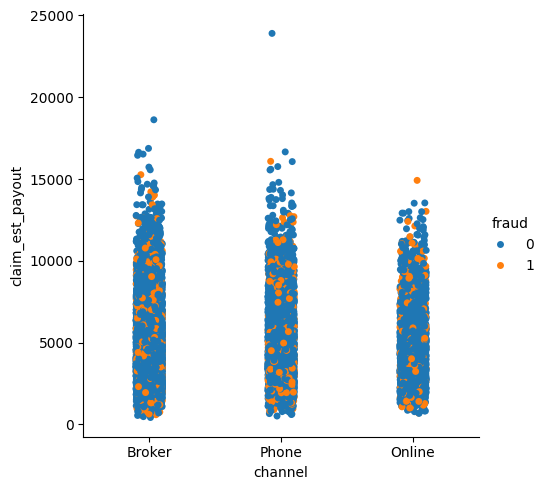

In [ ]:
sns.catplot(data=df, x="channel", y="claim_est_payout", hue="fraud", jitter=True )

This graph shows us that there is no significant difference between the estimated claim payout for fraudulent vs non-fraudulent claims by channel

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# Group data by 'channel' and 'fraud', count claims
tmp3 = df.groupby(['channel', 'fraud'])['claim_number'].count()

# Calculate the total claims per channel
total_claims_per_channel = tmp3.groupby(level=0).transform('sum')

# Calculate the percentage
percentage = (tmp3 / total_claims_per_channel) * 100

# Create a DataFrame with both count and percentage
result = pd.DataFrame({
    'Count': tmp3,
    'Percentage': percentage
})

# Display the final table
result

Count  Percentage
channel fraud                   
Broker  0       8608   84.616141
        1       1565   15.383859
Online  0       2316   83.640303
        1        453   16.359697
Phone   0       5138   84.813470
        1        920   15.186530

From this table we can see that the channels have the following percentage of fraudulent claims:

Broker: 15.4%

Online: 16.4%

Phone: 15.2%

This shows us that it is more likely that an online policy submits a fraudulent claim than Broker or Phone Policies.

### ◼ Plot-4 and table-4

Lets look at a few of our categorical splits to see if any of those distributions stand out.

<Axes: xlabel='living_status'>

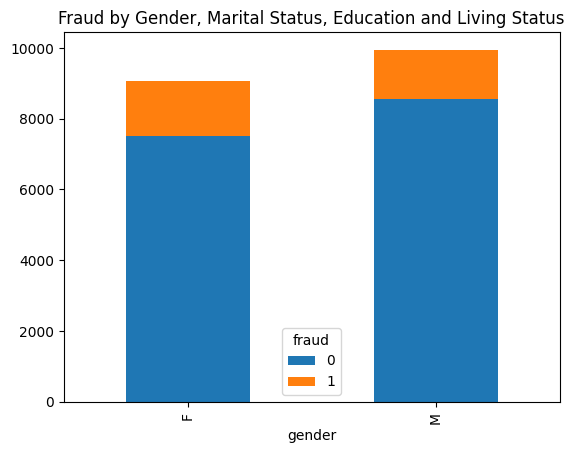

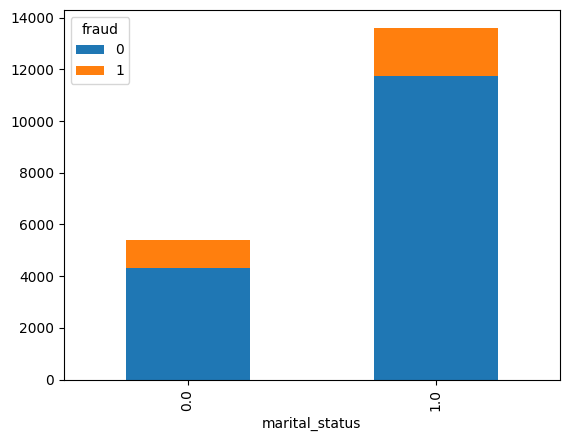

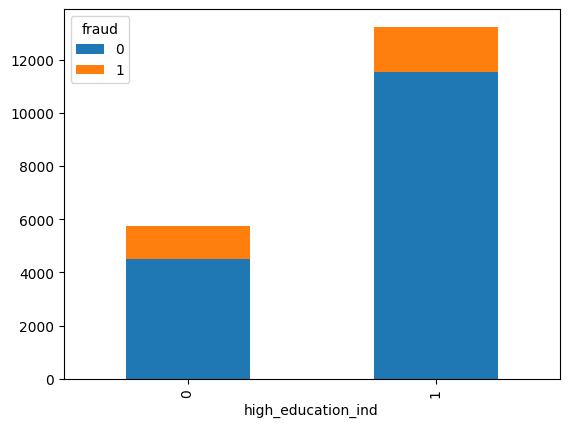

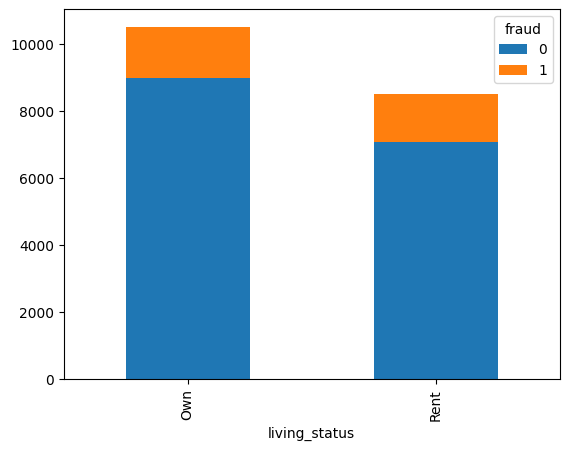

In [ ]:
tmp1 = df.groupby(['gender', 'fraud'])['claim_number'].count().unstack().fillna(0)
tmp1.plot(kind='bar', stacked=True)
plt.title('Fraud by Gender, Marital Status, Education and Living Status')

tmp2 = df.groupby(['marital_status', 'fraud'])['claim_number'].count().unstack().fillna(0)
tmp2.plot(kind='bar', stacked=True)

tmp3 = df.groupby(['high_education_ind', 'fraud'])['claim_number'].count().unstack().fillna(0)
tmp3.plot(kind='bar', stacked=True)

tmp4 = df.groupby(['living_status', 'fraud'])['claim_number'].count().unstack().fillna(0)
tmp4.plot(kind='bar', stacked=True)


It doesnt look like there are significant differences in any of our splits, so lets look at the tables.

In [ ]:
print('Fraud by Gender')
tmp1 = df.groupby(['gender', 'fraud'])['claim_number'].count().unstack().fillna(0)
print(tmp1)
print('')
print('Fraud by Marital Status')
tmp2 = df.groupby(['marital_status', 'fraud'])['claim_number'].count().unstack().fillna(0)
print(tmp2)
print('')
print('Fraud by Higher Education indicator')
tmp3 = df.groupby(['high_education_ind', 'fraud'])['claim_number'].count().unstack().fillna(0)
print(tmp3)
print('')
print('Fraud by Living Status (Own/Rent)')
tmp4 = df.groupby(['living_status', 'fraud'])['claim_number'].count().unstack().fillna(0)
print(tmp4)

Fraud by Gender
fraud      0     1
gender            
F       7499  1555
M       8563  1383

Fraud by Marital Status
fraud               0     1
marital_status             
0.0              4316  1067
1.0             11742  1871

Fraud by Higher Education indicator
fraud                   0     1
high_education_ind             
0                    4520  1240
1                   11542  1698

Fraud by Living Status (Own/Rent)
fraud             0     1
living_status            
Own            8988  1520
Rent           7074  1418


When we look at these tables in totality, we can see that there is not a significant difference for gender, or living_staus, but there is a significant difference for marital_status (not married people are more likely to commit fraudulent claims), and high_education_ind (higher education people are less likely to commit fraud).

### ◼ Plot-5 and table-5

Create a correlation heatmap to see which variables correlate to one another.

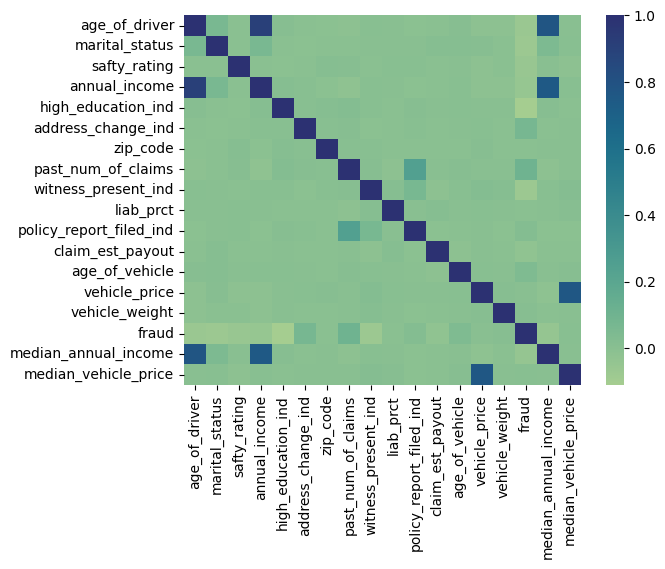

In [ ]:
df2 = df.drop(['claim_number'],axis=1)
corr = df2.corr(numeric_only=True)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="crest")
plt.show()

For this dataset, we can see that there is a slight correlation between fraud and address_change_ind, past_num_of_claims, and age_of_vehicle. This makes sense becuase it would reason that it is more likely there is fraud if you have more prior claims, have changed your address, or have an older vehicle. Lets look at the table breakdowns for these three variables

In [ ]:
# Create a table to get the count of fraud and non-fraud claims by channel
tmp1 = df.groupby(['address_change_ind','fraud'])['claim_number'].count()
print('Address Change Indicator')
print(tmp1)
print('')

tmp2 = df.groupby(['past_num_of_claims','fraud'])['claim_number'].count()
print('Past Number of Claims')
print(tmp2)
print('')

tmp3 = df.groupby(['age_of_vehicle','fraud'])['claim_number'].count()
print('Age of Vehicle')
print(tmp3)

Address Change Indicator
address_change_ind  fraud
0                   0        7073
                    1        1021
1                   0        8989
                    1        1917
Name: claim_number, dtype: int64

Past Number of Claims
past_num_of_claims  fraud
0                   0        11573
                    1         1816
1                   0         2694
                    1          543
2                   0         1106
                    1          309
3                   0          456
                    1          163
4                   0          116
                    1           48
5                   0           90
                    1           52
6                   0           27
                    1            7
Name: claim_number, dtype: int64

Age of Vehicle
age_of_vehicle  fraud
0.0             0         120
                1          14
1.0             0         611
                1          77
2.0             0        1386
                1   

These tables show us that:

1) Address Change Indicator = 1 has a much higher percentage of fraud than those without an address change (18% vs 13%)

2) Past Number of Claims shows us that as the past number of claims increase, the percentage of claims identified as Fraudulent also increase from 14% with no past claims to 37% with 5 past claims.

3) Age of vehicle shows us that as the age of the vehicle increases, for the most part the percentage of fraudulent claims also increases.

# 🔴 Feature Engineering - Drop few columns, Scale the data, and Perform PCA

We decided to drop zip_code and claim_date from our model as they don't provide predictive power. zip codes can cause overfitting with their high specificity(too many unique categories), and claim dates do not directly correlate with fraud(particular date resulted in fraud claim doesn't make sense).Thus dropping those columns and avoid unnecessary model complexity

In [ ]:
X_train['zip_code'].nunique()

276

In [ ]:
X_train['claim_date'].nunique()

731

### ◼ Train

In [ ]:
# Drop claim_date,zip_code columns as they have too many categories (claim_date : 731 categories, zip_code: 276)
X_train = X_train.drop(['claim_date','zip_code'],axis=1)
X_train.shape

(15200, 33)

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Check the distribution
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.describe()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,accident_site,past_num_of_claims,...,claim_day_Thursday,claim_day_Tuesday,claim_day_Wednesday,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white
count,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,...,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000
mean,0.098374,0.476776,0.717566,0.732024,0.663377,0.699211,0.571579,0.553487,0.359013,0.083235,...,0.147500,0.143355,0.140789,0.145789,0.140855,0.142895,0.140987,0.142566,0.143618,0.143289
std,0.046597,0.499477,0.450198,0.156291,0.053251,0.458616,0.494866,0.497147,0.393953,0.158142,...,0.354615,0.350446,0.347816,0.352907,0.347884,0.349977,0.348019,0.349641,0.350714,0.350379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.065385,0.000000,0.000000,0.646465,0.631726,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.096154,0.000000,1.000000,0.757576,0.668278,1.000000,1.000000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.126923,1.000000,1.000000,0.848485,0.698664,1.000000,1.000000,1.000000,0.500000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# PCA
pca = PCA(0.92)
X_train_pca = pca.fit_transform(X_train_scaled)
X_train_pca.shape

(15200, 22)

### ◼ Test

In [ ]:
# Drop claim_date,zip_code columns as they have too many categories
X_test = X_test.drop(['claim_date','zip_code'],axis=1)
X_test.shape

(3800, 33)

In [ ]:
# Scale the data using transform()
X_test_scaled = scaler.transform(X_test)

In [ ]:
# PCA using transform()
X_test_pca = pca.transform(X_test_scaled)
X_test_pca.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(3800, 22)

# 🔴 Oversampling - Train Data Set

In [ ]:
# Check the count of target classes in train set
print(Counter(y_train))

Counter({0: 12853, 1: 2347})


Since there is a huge difference between target classes, and the dataset includes all numerical columns I opt for SMOTE as an oversampling technique to balance both the target classes. And also the no.of columns are more, it isn't recommended to do undersampling as we may end up with curse of dimensionality.

In [ ]:
# Initialize SMOTE
sampler = SMOTE()

# Fit and transform X_train and y_train
X_train_os,y_train_os = sampler.fit_resample(X_train_scaled,y_train)

# Confirm the oversampling by checking the target class counts
print(Counter(y_train_os))

Counter({0: 12853, 1: 12853})


In [ ]:
# Check shape of X_train_os and y_train_os
print('X_train_os:',X_train_os.shape,'\n','y_train_os:',y_train_os.shape)

X_train_os: (25706, 33) 
 y_train_os: (25706,)


After completing data cleaning, feature engineering, and oversampling, we are now moving on to the modeling phase.

We'll use X_train_os and y_train_os for fitting the model, and X_test_scaled and y_test for evaluating its performance.

# 🔴 Model

We tried the following classifier models before choosing our best model:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosting Classifier
* XGBoost Classifier

We also implemented hyperparameter tuning, and grid search. However, Gradient Boosting Classifier with default parameters and probability threshold 0.34 (i.e,cutoff=0.34) turned out to be our best model.

### ✅ Gradient Boosting Classifier

In [ ]:
# Initialize the model with the important parameters
GBC = GradientBoostingClassifier(
    learning_rate=0.1,        # Shrinks the contribution of each tree
    n_estimators=100,         # The number of boosting stages to be run
    max_depth=3,              # The maximum depth of the individual regression estimators
    min_samples_split=2,      # The minimum number of samples required to split an internal node
    min_samples_leaf=1        # The minimum number of samples required to be at a leaf node
)

# Fit the training data
GBC.fit(X_train_os, y_train_os)

GradientBoostingClassifier()

In [ ]:
# Predict probabilities for the train and test set
train_proba_GBC = GBC.predict_proba(X_train_os)[:, 1]  # Get the probabilities of the positive class
test_proba_GBC = GBC.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of the positive class

# Define a new cutoff value
cutoff = 0.38  # Lowering the threshold to make the model more sensitive

# Apply the cutoff to the train and test probabilities to make final predictions
y_train_GBC = (train_proba_GBC > cutoff).astype(int)
y_test_GBC = (test_proba_GBC > cutoff).astype(int)

# Evaluate the model on the train data
print('###Train###\n')
print("Accuracy:", accuracy_score(y_train_os, y_train_GBC))
print("Confusion Matrix:\n", confusion_matrix(y_train_os, y_train_GBC))
print("Classification Report:\n", classification_report(y_train_os, y_train_GBC))

# Evaluate the model on the test data
print('###Test###\n')
print("Accuracy:", accuracy_score(y_test, y_test_GBC))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_GBC))
print("Classification Report:\n", classification_report(y_test, y_test_GBC))


###Train###

Accuracy: 0.8946549443709639
Confusion Matrix:
 [[12048   805]
 [ 1903 10950]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     12853
           1       0.93      0.85      0.89     12853

    accuracy                           0.89     25706
   macro avg       0.90      0.89      0.89     25706
weighted avg       0.90      0.89      0.89     25706

###Test###

Accuracy: 0.815
Confusion Matrix:
 [[2973  236]
 [ 467  124]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      3209
           1       0.34      0.21      0.26       591

    accuracy                           0.81      3800
   macro avg       0.60      0.57      0.58      3800
weighted avg       0.78      0.81      0.80      3800



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


GradientBoosting classifier with probability threshold = 0.38 (i.e,cutoff=0.38)gave the best weighted F-1 score(0.80) on test data set.

# 🔴 Model Results


In [ ]:
# Verify the shape of test set to ensure there is no data  leakage
# 3209+591 = 3800
y_test.shape

(3800,)

### ✅Confusion Matrix

In [ ]:
print('###Train###\n')
print("Confusion Matrix:\n", confusion_matrix(y_train_os, y_train_GBC))

print('###Test###\n')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_GBC))


###Train###

Confusion Matrix:
 [[12048   805]
 [ 1903 10950]]
###Test###

Confusion Matrix:
 [[2973  236]
 [ 467  124]]


### ✅ Classification Report

In [ ]:

print('###Train###\n')
print("Classification Report:\n", classification_report(y_train_os, y_train_GBC))

print('###Test###\n')
print("Classification Report:\n", classification_report(y_test, y_test_GBC))

###Train###

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     12853
           1       0.93      0.85      0.89     12853

    accuracy                           0.89     25706
   macro avg       0.90      0.89      0.89     25706
weighted avg       0.90      0.89      0.89     25706

###Test###

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      3209
           1       0.34      0.21      0.26       591

    accuracy                           0.81      3800
   macro avg       0.60      0.57      0.58      3800
weighted avg       0.78      0.81      0.80      3800



From the confusion matrix and classification reports for both training and testing sets, we can observe the following:

* The model shows consistent precision, recall, and F1-score values between the training and testing sets, indicating that it is not overfitting and performs well on new, unseen data.

* The model is highly effective at identifying non-fraudulent claims in the test set, as shown by high scores in precision (0.86), recall (0.93), and F1-score (0.90).

* However, the model's performance drops significantly when identifying fraudulent claims in the test set, with lower precision (0.35), recall (0.21), and F1-score (0.26). This discrepancy from the training set results could be due to an imbalance in the distribution of fraudulent and non-fraudulent claims in the test data.

# 🔴 Interpretability

##Permutation Top 5 Variables

Now lets use permutation importance to determine our top 5 variables

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py

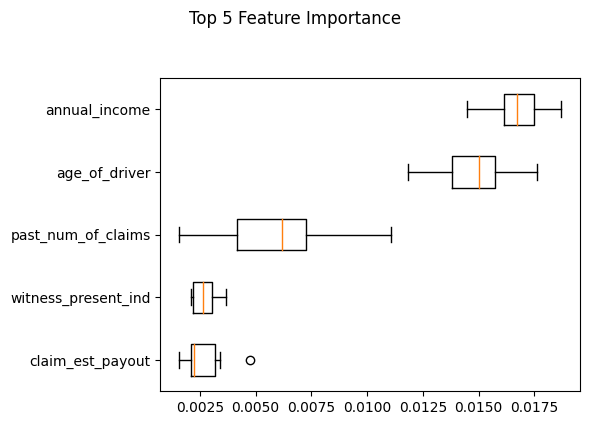

In [ ]:
from sklearn.inspection import permutation_importance

# Assign our model to clf
clf = GBC
result = permutation_importance(clf, X_test_scaled, y_test, n_repeats=10,
                                random_state=8)
perm_sorted_idx = result.importances_mean.argsort()

# Get the indices of the top 5 most important features
top_5_PI_features = perm_sorted_idx[-5:]

# Sort the indices of the top 5 features
top_5_PI_features = top_5_PI_features[np.argsort(result.importances_mean[top_5_PI_features])]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# Box plot of the top 5 variables
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[top_5_PI_features].T, vert=False,
            labels=X_test.columns[top_5_PI_features])
fig.suptitle('Top 5 Feature Importance', y=1.05)
fig.tight_layout()
plt.show()


From the above graph, we can see the Gradient Boosting classifier model gives us the following top 5 variables:

1) annual_income

2) age_of_driver

3) past_num_of_claims

4) witness_present_ind

5) claim_est_payout

From our EDA, We have seen that lower annual income, higher past no.of claims are indicators of fraud.

let's explore more on relationship of age_of_driver, witness_present_ind, claim_est_payout associated with fraud status.

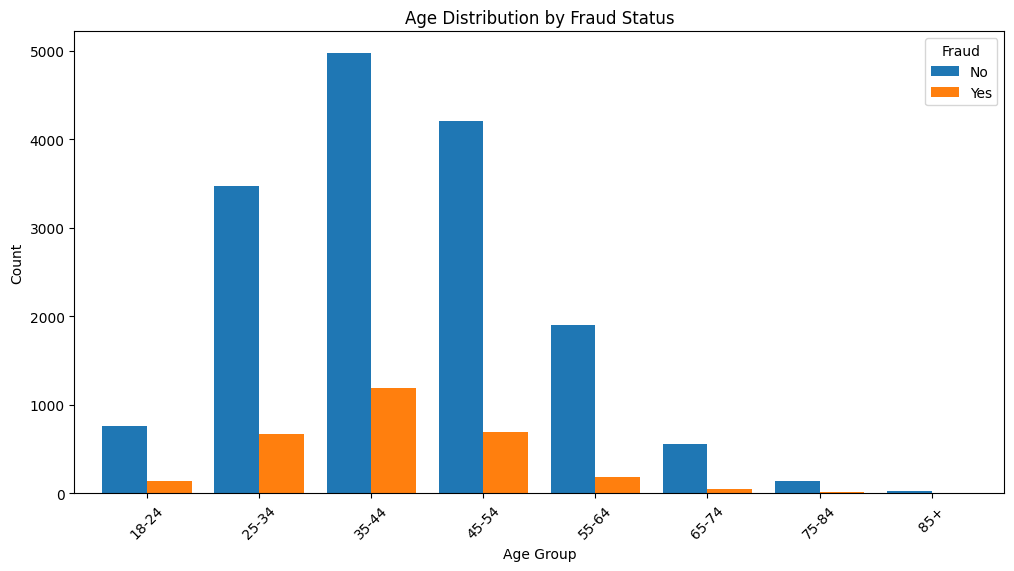

In [ ]:
# age_of_driver vs fraud status
# Define age bins
bins = [18, 25, 35, 45, 55, 65, 75, 85, 95]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
df['age_group'] = pd.cut(df['age_of_driver'], bins=bins, labels=labels)

# Prepare the data for plotting
age_distribution = df.groupby(['age_group', 'fraud'])['age_group'].count().unstack(fill_value=0)
# Plotting
age_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Age Distribution by Fraud Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Fraud', labels=['No', 'Yes'])
plt.show()

Middle-aged drivers (35-54) show higher overall claims and a relatively higher proportion of fraud. This can be a good indicator of fraud.

In [ ]:
# witness_present_ind vs fraud status

# Create a table to get the count of fraud and non-fraud claims grouping on witnesss_present_ind
tmp1 = df.groupby(['witness_present_ind','fraud'])['claim_number'].agg(Count='count')
tmp1['Percentage'] = tmp1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values

# Display the table with counts and percentages
tmp1


Count  Percentage
witness_present_ind fraud                   
0.0                 0      11941   82.981237
                    1       2449   17.018763
1.0                 0       3993   89.388852
                    1        474   10.611148

The table suggests that claims involving a witness are less likely to be fraudulent, with only about 10.61% marked as fraud, compared to claims without a witness where approximately 17.02% are fraudulent. This highlights a potential factor in assessing the risk of fraud.







PI plots and Our analysis highlights that past number of claims, driver's age, annual income, and witness presence are crucial indicators of fraud in insurance claims. We also identified address changes as a potential fraud indicator. Surprisingly, while claim estimated payout ranked in the top five indicators, it didn't show a strong correlation with fraud in our detailed analysis, unlike address change, which was not ranked as highly but showed potential relevance.

##Partial Dependence Top 5 Variables

In [ ]:
!pip install pycebox
from pycebox.ice import ice, ice_plot

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
<ipython-input-186-cef0a71c892d>:17: UserWarning: 

`di

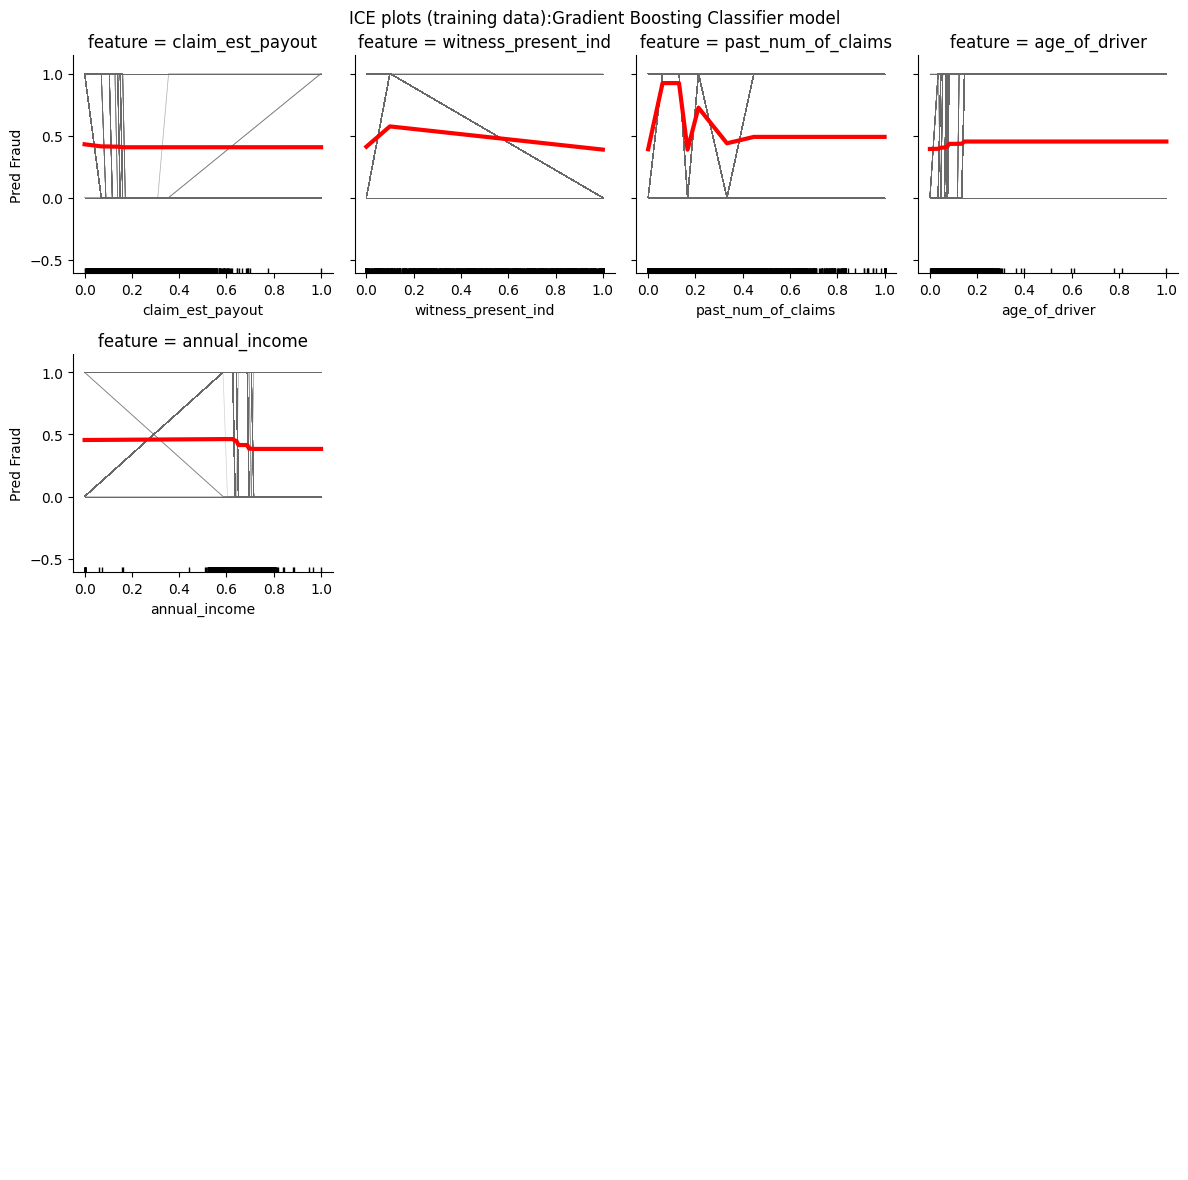

In [ ]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=4,
                  ncols=4, figsize=(12, 12), sharex=False, sharey=True,
                  num_grid_points = 10, # DW added this on 4/27/2022!
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False,
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()

    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

# columns to plot
features = [X_train_os.columns[i] for i in top_5_PI_features]

# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=X_train_os, column=feat,
predict=GBC.predict,num_grid_points=20)
                 for feat in features}

plot_ice_grid(train_ice_dfs, X_train_os, features,
                    ax_ylabel='Pred Fraud', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
#plt.ylim([0,50])
plt.suptitle('ICE plots (training data):Gradient Boosting Classifier model')
plt.subplots_adjust(top=0.89)
plt.tight_layout()
plt.show()

From PDP plots

* **claim_est_payout:** The plot shows varying predictions across different payout values with no consistent trend, indicating that claim estimated payout does not have a uniform impact on fraud prediction across its range.

* **witness_present_ind:** The decreasing trend in predictions as the witness present indicator changes from 0 to 1 suggests that having a witness present generally corresponds to a lower likelihood of a claim being fraudulent.

* **annual_income:** This plot shows higher annual income slightly correlates with a lower probability of fraud, suggesting that higher income individuals might be less likely to commit fraud.

* **age_of_driver:** The plot indicates that the age of the driver has minimal variation in fraud prediction across different ages, suggesting that age alone does not significantly influence fraud prediction in the model.

* **past_num_of_claims:** The plot shows a notable increase in the likelihood of fraud as the number of past claims increases from 0 to 1 and then fluctuates. This indicates that an initial history of claims is a strong predictor of potential fraud, but additional claims do not linearly increase fraud probability.

#Conclusions

**Bullet 1:** The decision to drop zip code and claim date were helpful when tuning our model.  As we stated above, the zip code is overly specific, so it likely was a cause of a lot of noise in our initial model iterations.  Additionally, removing claim data helped.  Claim date does not necessarily mean that is when the accident happened, as it could take days for a claim to be reported. If we had information on date of accident to compare to claim date to see how long it took to report the claim, may have been helpful or impactful, though that is presumptive.

**Bullet 2:** As we can see from the information above, claim_est_payout, witness_present_ind, annual_income, age_of_driver, and past_num_of_claims are the most impactful variables when trying to identify fraudulent claims.  These stand to reason, because it would be expected that the cost of a claim or the number of claims someone has had in the past would increase the likelihood of a subsequent claim being fraudulent.

**Bullet 3:** Our weighted average F1 test score of 80% for the test dataset indicates that our model performs relatively well on a scale of 0 to 1. Our Test dataset's Precision of 0.78 and 0.81 indicate that 78% of our positive predictions were truly positive, and 81% of our true positives were actual positives.

**Bullet 4:** When looking at the confusion matrix, we can understand how many of our values were

**1) True Positives:** Predicted positive and actually positive.

**2) False Negative:** Predicted Negative and actually positive.

**3) False Positive:** Predicted Positive and actually negative.

**4) True Negative:** Predicted Negative and actually negative.

Ideally, we would want our values to be concentrated in True Positive and True Negative.  

In our train dataset, we see that 90% of our values are True Positives and True Negatives.  With 7% in the False Postiive section, and 3% in the False Negative section, the model has a higher chance of indicating something is Fraud when it is not, vs the alternative.

For our test dataset we see that 81% of our values are True Positives and True Negatives. 6% are False Negatives and 12% are False Positives, so the model has a higher chance of indicating something isnt Fraud when it is.

**Bullet 5:** Our choice to use SMOTE as an oversampling technique also improved our model performance. Since there is a huge difference between target classes, and the dataset includes all numerical columns SMOTE is a good choice as an oversampling technique to balance both the target classes. Also  because of the number of columns, it isn't recommended to do undersampling as we may end up with curse of dimensionality.